In [147]:
library(forecast)
library(ggplot2)
library(dplyr)
library(gridExtra)

In [148]:
# library(doParallel)
library(doMC)
options(cores = 10)
registerDoMC()
require(svMisc)

In [149]:
library(data.table)
library(hts)  

### ЕС

In [150]:
df_eu  <-  read.csv(file="hts_eu_a10.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [151]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [152]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(3,0,0)
var_sarpdq   <-  c(2,0,0)
var_char  <-  c(2,1)

In [153]:
75-69

[1] 6

In [154]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = var_char)
s  <-  smatrix(y)
gts_train  <- window(y, start=20, end=67)
gts_test  <- window(y, start=68, end=75)
allts <- aggts(gts_train)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

In [155]:
start_time <- Sys.time()
ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="CSS"))
    }

end_time <- Sys.time()
end_time - start_time

Time difference of 2.197154 secs

In [156]:
library('Rfast')

ERROR: Error in library("Rfast"): there is no package called ‘Rfast’


In [ ]:
# colVars(allf)

sapply(allf, var)

In [ ]:
for(i in 1:ncol(allts)){
    allf[,i] <- forecast(ms[[i]], h=var_h)$mean
    }
allf <- ts(allf)
colnames(allf)  <-  colnames(allts)  
# combine the forecasts with the group matrix to get a gts object
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g, weights = sapply(allf, var), algorithms = "lu")
forecasts_7 = y.f[[1]]
colnames(forecasts_7) = colnames(y[[1]])
data_f5 = rbind(gts_train[[1]], forecasts_7)
y_f5 = hts(data_f5, characters = var_char)
plot(y_f5, levels = c(0, 1, 2), include = 30)

In [ ]:
gts_forecasts_7  <- window(y_f5,  start=dim(y_f5[[1]])[1]-var_h+1)
accuracy.gts(gts_forecasts_7, gts_test)

In [ ]:
var_acc_metrics  <-  c(1,2,5)

In [ ]:
accuracy.gts(gts_forecasts_7, gts_test)[var_acc_metrics,1]

In [ ]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
            
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="CSS"))
    }
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    for(j in 1:ncol(allts)){
        allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    }
    
            
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = sapply(allf, var), algorithms = "lu")
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = var_char)
        
            
            
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }

            
            
    print(gts_forecasts_7)
    print(gts_test)
            
            
    
    l[[k]]  <- allf

    ac[[i+1]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

            
            
    progress(i, progress.bar = TRUE)
            
    }

In [ ]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [157]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [158]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [159]:
df_acc

ME,RMSE,MAPE,Iteration
-25.10788,39.79210,1.0469576,1
-19.10680,30.64221,0.8587702,17
56.58739,73.48258,1.7092086,33
60.65981,66.00735,1.8157914,49
-63.86244,71.66316,1.9413245,65
85.23901,89.44994,2.4512776,76


In [160]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 3382.563 3436.319 3425.729 3476.709 3442.388 3484.096 3474.481 3525.213

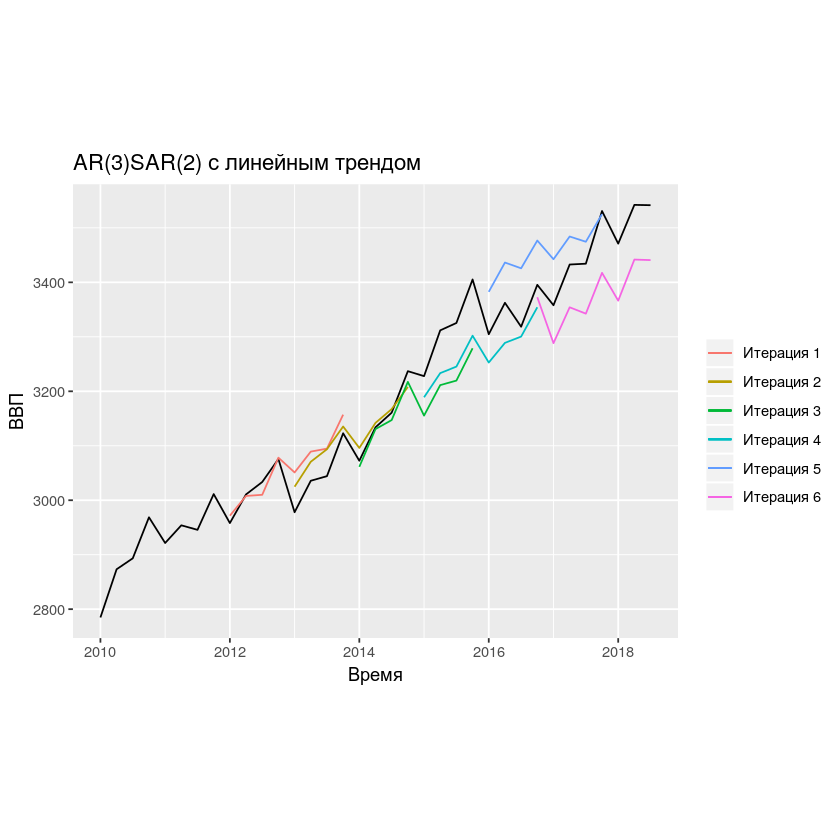

In [161]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [166]:
df_mean_acc <- readRDS("df_mean_acc.rds")
rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )
# df_mean_acc = rbind(df_mean_acc,c(rep('NA',3)))

In [167]:
rownames(df_mean_acc)[6]  <-  '3 Weighted'

In [169]:
colMeans(df_acc)[[2]]

[1] 61.83956

In [168]:
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.839556091108,242.038512753,8410.94107503333
3 level,62.0596739605785,242.432632797146,9616.41574753439
2 level (state),62.0365866565657,241.696134642821,11173.0672424215
2 level (type),61.8934203477981,242.432733556294,11046.8137227099
2 level (clusetered),62.2035745560281,242.160670839515,11124.9501222341
3 Weighted,61.8395575588501,NA,NA


In [121]:
df_mean_acc[6,1]   <- colMeans(df_acc)[[2]]

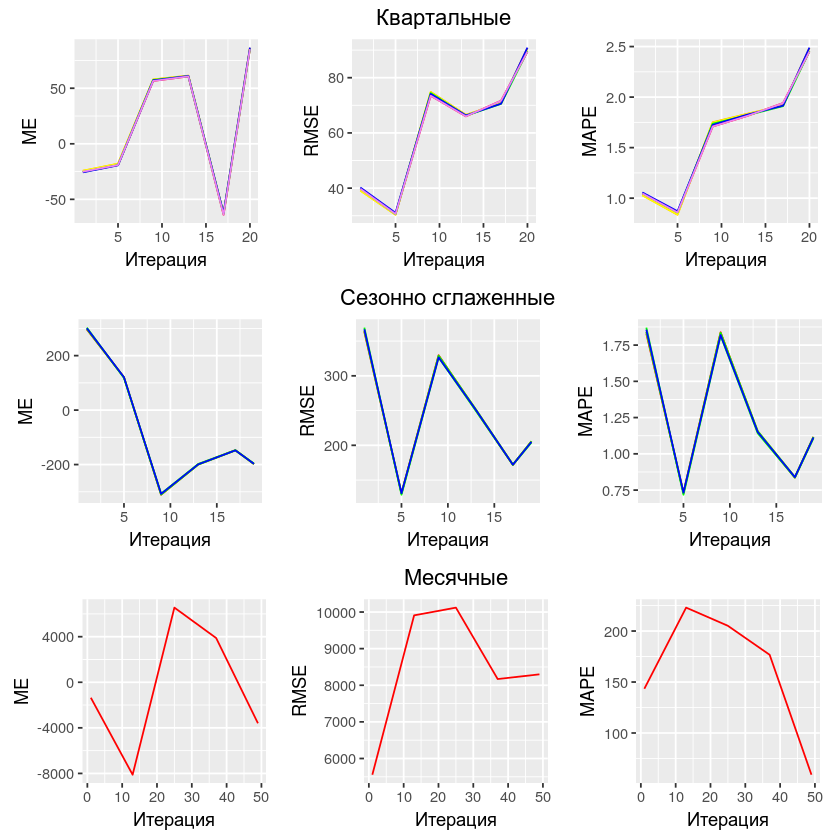

In [122]:
# Basic line plot with points

plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'violet'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 0
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### t

In [123]:
df_eu  <-  read.csv(file="hts_eu_a10_clust.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [124]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [125]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(3,0,0)
var_sarpdq   <-  c(2,0,0)
var_char  <-  c(2,1)

In [126]:
75-69

[1] 6

In [127]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
gts_train  <- window(y, start=20, end=67)
gts_test  <- window(y, start=68, end=75)
allts <- aggts(gts_train)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [128]:
start_time <- Sys.time()
ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="CSS"))
    }

end_time <- Sys.time()
end_time - start_time

Time difference of 0.1657257 secs

Since argument characters are not specified, the default labelling system is used.


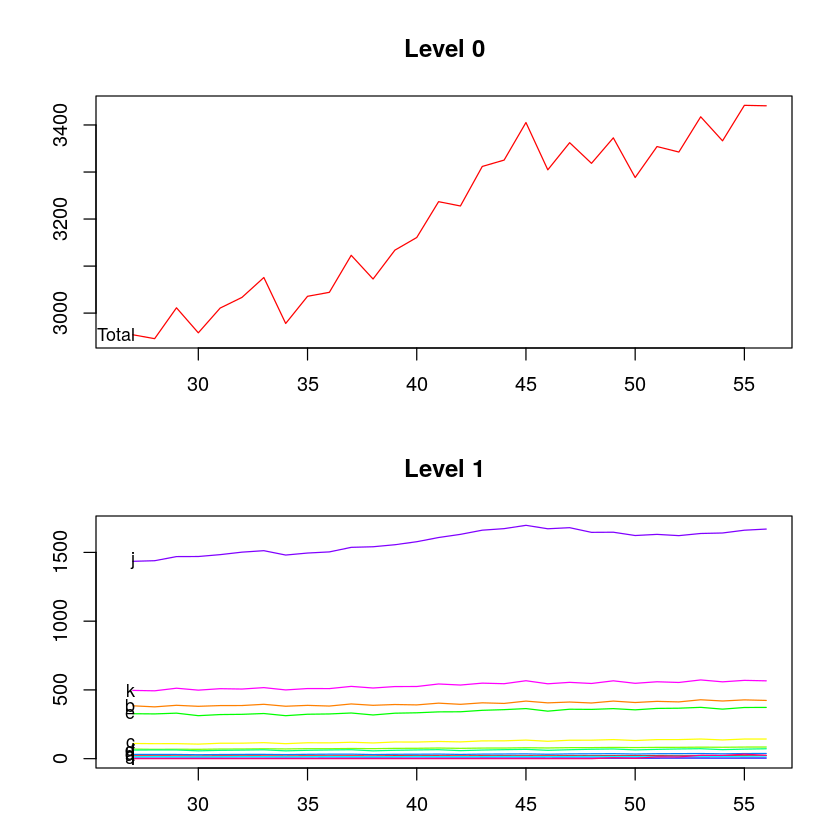

In [131]:
for(i in 1:ncol(allts)){
    allf[,i] <- forecast(ms[[i]], h=var_h)$mean
    }
allf <- ts(allf)
colnames(allf)  <-  colnames(allts)  
# combine the forecasts with the group matrix to get a gts object
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g,  weights = sapply(allf, var))
forecasts_7 = y.f[[1]]
colnames(forecasts_7) = colnames(y[[1]])
data_f5 = rbind(gts_train[[1]], forecasts_7)
y_f5 = hts(data_f5)
plot(y_f5, levels = c(0, 1), include = 30)

In [132]:
gts_forecasts_7  <- window(y_f5,  start=dim(y_f5[[1]])[1]-var_h+1)
accuracy.gts(gts_forecasts_7, gts_test)

,Total,a,b,c,d,e,f,g,h,i,j,k,l
ME,85.239008,0.8141726,4.998490,6.209917,2.561774,11.930029,2.316590,0.5578297,1.279018,0.1563083,64.435367,7.439963,-17.46045
RMSE,89.449944,0.9186523,5.392878,6.826357,2.848981,12.970670,2.857379,0.6794750,1.526711,0.1907115,67.247553,9.583755,19.96050
MAE,85.239008,0.8300890,4.998490,6.209917,2.561774,11.930029,2.316590,0.5578297,1.306235,0.1563083,64.435367,8.663058,17.46045
MAPE,2.451278,3.4992980,1.176109,4.214210,2.962761,3.122362,3.144912,3.0373348,3.395540,3.3043674,3.764329,1.510985,27469.41295
MPE,2.451278,3.4266476,1.176109,4.214210,2.962761,3.122362,3.144912,3.0373348,3.320233,3.3043674,3.764329,1.293052,-27469.41295


In [133]:
var_acc_metrics  <-  c(1,2,5)

In [134]:
accuracy.gts(gts_forecasts_7, gts_test)[var_acc_metrics,1]

ME      RMSE       MPE 
85.239008 89.449944  2.451278

In [135]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
            
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = TRUE, include.mean = TRUE, method="CSS"))
    }
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    for(j in 1:ncol(allts)){
        allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    }
    
            
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g,  weights = sapply(allf, var))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }

            
            
    print(gts_forecasts_7)
    print(gts_test)
            
            
    
    l[[k]]  <- allf

    ac[[i+1]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

            
            
    progress(i, progress.bar = TRUE)
            
    }

[1]  1 48 49 56


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2971.645 3007.880 3009.976 3078.114 3051.004 3089.243 3094.726 3157.097
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2958.070 3010.722 3033.490 3075.700 2977.965 3035.742 3044.227 3122.905
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 52 53 60


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3024.831 3070.625 3093.688 3135.335 3095.962 3142.019 3167.319 3207.981
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 53 
End = 60 
Frequency = 1 
[1] 2977.965 3035.742 3044.227 3122.905 3072.484 3133.907 3160.757 3236.918
[1]  9 56 57 64


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3061.328 3130.650 3147.169 3217.262 3155.311 3211.313 3219.616 3278.956
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 57 
End = 64 
Frequency = 1 
[1] 3072.484 3133.907 3160.757 3236.918 3227.776 3311.839 3325.372 3405.251
|[1] 13 60 61 68


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3188.981 3233.321 3245.324 3302.022 3252.765 3288.886 3300.394 3354.185
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 61 
End = 68 
Frequency = 1 
[1] 3227.776 3311.839 3325.372 3405.251 3304.666 3362.395 3318.470 3395.389
|[1] 17 64 65 72


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3382.563 3436.319 3425.729 3476.709 3442.388 3484.096 3474.481 3525.213
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 65 
End = 72 
Frequency = 1 
[1] 3304.666 3362.395 3318.470 3395.389 3357.919 3432.684 3434.182 3530.894
[1] 21 68 69 76


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3372.650 3288.321 3354.156 3342.478 3417.416 3366.316 3441.794 3440.801
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 12 
Total number of series: 13 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 68 
End = 75 
Frequency = 1 
[1] 3395.389 3357.919 3432.684 3434.182 3530.894 3471.013 3542.181 3541.582


In [136]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [137]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [138]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [139]:
df_acc

ME,RMSE,MAPE,Iteration
-25.10788,39.79210,1.0469576,1
-19.10680,30.64221,0.8587702,5
56.58739,73.48258,1.7092086,9
60.65981,66.00735,1.8157914,13
-63.86244,71.66316,1.9413245,17
85.23901,89.44994,2.4512776,20


In [140]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 3382.563 3436.319 3425.729 3476.709 3442.388 3484.096 3474.481 3525.213

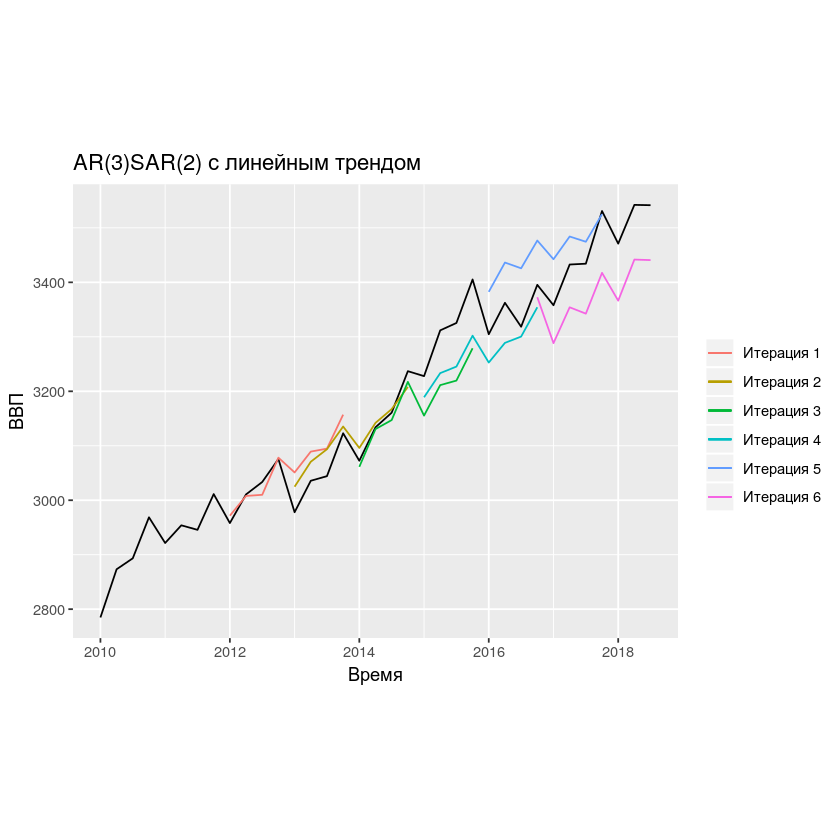

In [141]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [142]:
colMeans(df_acc)

ME      RMSE      MAPE Iteration 
15.734847 61.839556  1.637222 10.833333

In [143]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [144]:
# df_mean_acc[5,1]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.839556091108,242.038512753,8410.94107503333
3 level,62.0596739605785,242.432632797146,NA
2 level (state),62.0365866565657,241.696134642821,NA
2 level (type),61.8934203477981,242.432733556294,NA
2 level (clusetered),62.2035745560281,242.160670839515,NA
3 Weighted,61.8395575588501,NA,NA


In [177]:
saveRDS(df_mean_acc, "df_mean_acc.rds")
saveRDS(plots_test_all, "plots_test_not_all.rds")

In [178]:
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.839556091108,242.038512753,8410.94107503333
3 level,62.0596739605785,242.432632797146,9616.41574753439
2 level (state),62.0365866565657,241.696134642821,11173.0672424215
2 level (type),61.8934203477981,242.432733556294,11046.8137227099
2 level (clusetered),62.2035745560281,242.160670839515,11124.9501222341
3 Weighted,61.8395575588501,NA,8923.37954762796


In [175]:
df_mean_acc[6,3]  <- 8923.37954762796

In [179]:
df_mean_acc

,AR(3)SAR(2),AR(4),AR(11)SAR(2)
1 level,61.839556091108,242.038512753,8410.94107503333
3 level,62.0596739605785,242.432632797146,9616.41574753439
2 level (state),62.0365866565657,241.696134642821,11173.0672424215
2 level (type),61.8934203477981,242.432733556294,11046.8137227099
2 level (clusetered),62.2035745560281,242.160670839515,11124.9501222341
3 Weighted,61.8395575588501,NA,8923.37954762796


In [180]:
saveRDS(df_mean_acc, "df_mean_acc.rds")